# Demo Notebook
This notebook demonstrates the use of the `PyOCN` library to create and optimize Optimal Channel Networks (OCNs) on a grid. It includes functions for generating random OCNs, optimizing them using simulated annealing, and visualizing the results.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import PyOCN as po

## Simple OCN Example

In [2]:
# initialize an OCN from one of the built-in network types with default parameters
ocn = po.OCN.from_net_type(
    net_type="E",
    dims=(50, 50),
    random_state=4000,
    verbosity=2,
    gamma=0.5
)

# optimize the OCN using simulated annealing and default parameters
result = ocn.fit(energy_reports=1000, array_reports=10, max_iterations_per_loop=1000)

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Successfully created FlowGrid_C from DiGraph.
102 12


OCN Optimization: 100%|██████████| 100k/100k [00:00<00:00, 358kit/s, Energy=-2.03e+3, T=3.64e-16, Relative ΔE=0.000232] 


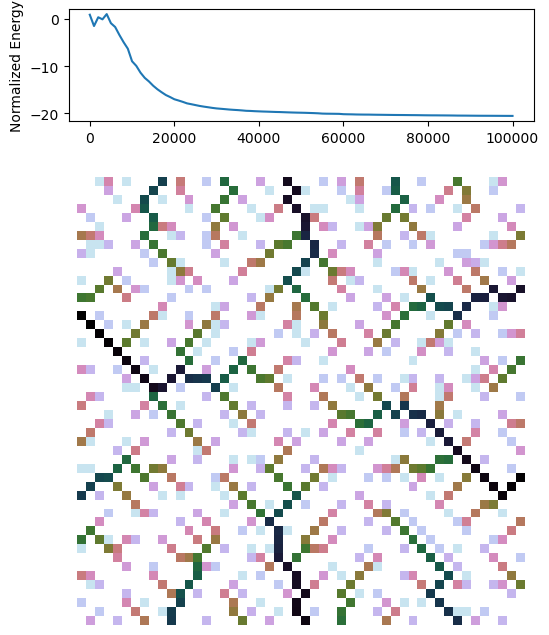

In [3]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(result.energy_idx, result.energies / np.max(result.energies))
axs[0].set_ylabel("Normalized Energy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[1])
axs[1].set_axis_off()

## Initializing an OCN from a custom DAG

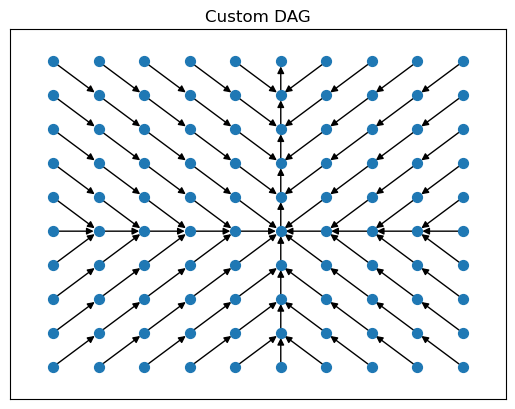

In [12]:
# initialize an OCN from a custom nx.DiGraph instance
from itertools import product

def cross_center_root(m, n):
    dag = nx.DiGraph()
    halfway_r = n // 2
    halfway_u = m // 2
    for i, (r, c) in enumerate(product(range(m), range(n))):
        dag.add_node(i, pos=(r, c))
        
    for i, (r, c) in enumerate(product(range(m), range(n))):
        # ul quadrant
        if r > halfway_u and c < halfway_r:
            dag.add_edge(i, i - n + 1)
        # ur quadrant
        elif r > halfway_u and c > halfway_r:
            dag.add_edge(i, i - n - 1)
        # ll quadrant
        elif r < halfway_u and c < halfway_r:
            dag.add_edge(i, i + n + 1)
        # lr quadrant
        elif r < halfway_u and c > halfway_r:
            dag.add_edge(i, i + n - 1)
        # middle column
        elif c == halfway_r:
            if r > 0:
                dag.add_edge(i, i - n)  # default up
            # if r > halfway_u:
            #     dag.add_edge(i, i - n)
            # elif r < halfway_u:
            #     dag.add_edge(i, i + n)
        # middle row
        else:
            if c > halfway_r:
                dag.add_edge(i, i - 1)
            elif c < halfway_r:
                dag.add_edge(i, i + 1)
    return dag

_, ax = po.plot_positional_digraph(cross_center_root(10, 10), node_size=50, arrowsize=10, with_labels=False)
ax.set_title("Custom DAG");


In [20]:
m, n = 100, 100
ocn = po.OCN.from_digraph(
    dag=cross_center_root(m, n),
    random_state=4000,
    verbosity=2
)

# optimize the OCN using simulated annealing and default parameters
result = ocn.fit(array_reports=1, cooling_rate=3)

Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Found 1 spanning trees.
	Edges connect only to adjacent nodes.
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.
400000 400000


OCN Optimization: 100%|██████████| 400k/400k [00:03<00:00, 101kit/s, Energy=3.05e+4, T=3.55e-48, Relative ΔE=-1.03e-5]  


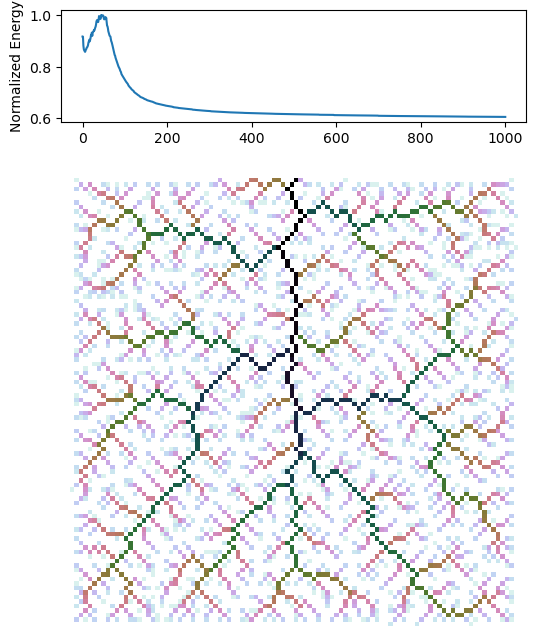

In [21]:
fig, axs = plt.subplots(2, 1, height_ratios=[1, 4], figsize=(6, 8))

axs[0].plot(result.energy_idx, result.energies / np.max(result.energies))
axs[0].set_ylabel("Normalized Energy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[1])
axs[1].set_axis_off()

## Modifying OCN parameters

In [24]:
def ocn_with_params(m, n, gamma, constant_phase, cooling_rate, n_iterations, dag):
    ocn = po.OCN.from_digraph(
        dag=dag,
        gamma=gamma,
        random_state=4000,
        verbosity=2
    )
    # this step is only needed to visualize the cooling schedule. Normally, this is handled internally by ocn.fit.
    cooling_schedule = po.utils.create_cooling_schedule(
        ocn=ocn, 
        constant_phase=constant_phase, 
        n_iterations=n_iterations, 
        cooling_rate=cooling_rate
    )
    result = ocn.fit(
        cooling_rate=cooling_rate,
        constant_phase=constant_phase,
        n_iterations=n_iterations,
        array_reports=1,
    )
    return ocn, result, cooling_schedule

m, n  = 100, 100
dag = cross_center_root(m, n)


Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 100x100 grid.
	Found 1 spanning trees.
	Edges connect only to adjacent nodes.
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.
2000000 2000000


OCN Optimization: 100%|██████████| 2.00M/2.00M [00:16<00:00, 122kit/s, Energy=2.8e+5, T=1.56e-7, Relative ΔE=-1.82e-5]  


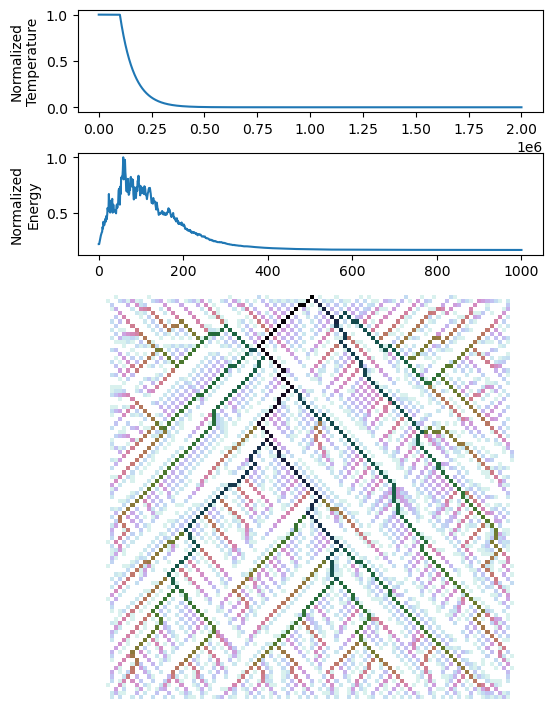

In [26]:
constant_phase = 0.05
cooling_rate = 0.15
n_iterations = m*n*200
gamma = 0.9
ocn, result, cooling_schedule = ocn_with_params(
    m, n, gamma, constant_phase, cooling_rate, n_iterations, dag
)

fig, axs = plt.subplots(3, 1, height_ratios=[1, 1, 4], figsize=(6, 9))

axs[0].plot(cooling_schedule(np.arange(n_iterations)) / cooling_schedule(0))
axs[0].set_ylabel("Normalized\nTemperature")

axs[1].plot(result.energy_idx, result.energies / np.max(result.energies))
axs[1].set_ylabel("Normalized\nEnergy")

norm = mpl.colors.LogNorm()
po.plot_ocn_raster(ocn, attribute='energy', norm=norm, cmap="cubehelix_r", ax=axs[2])
axs[2].set_axis_off()

## Plotting OCN progression

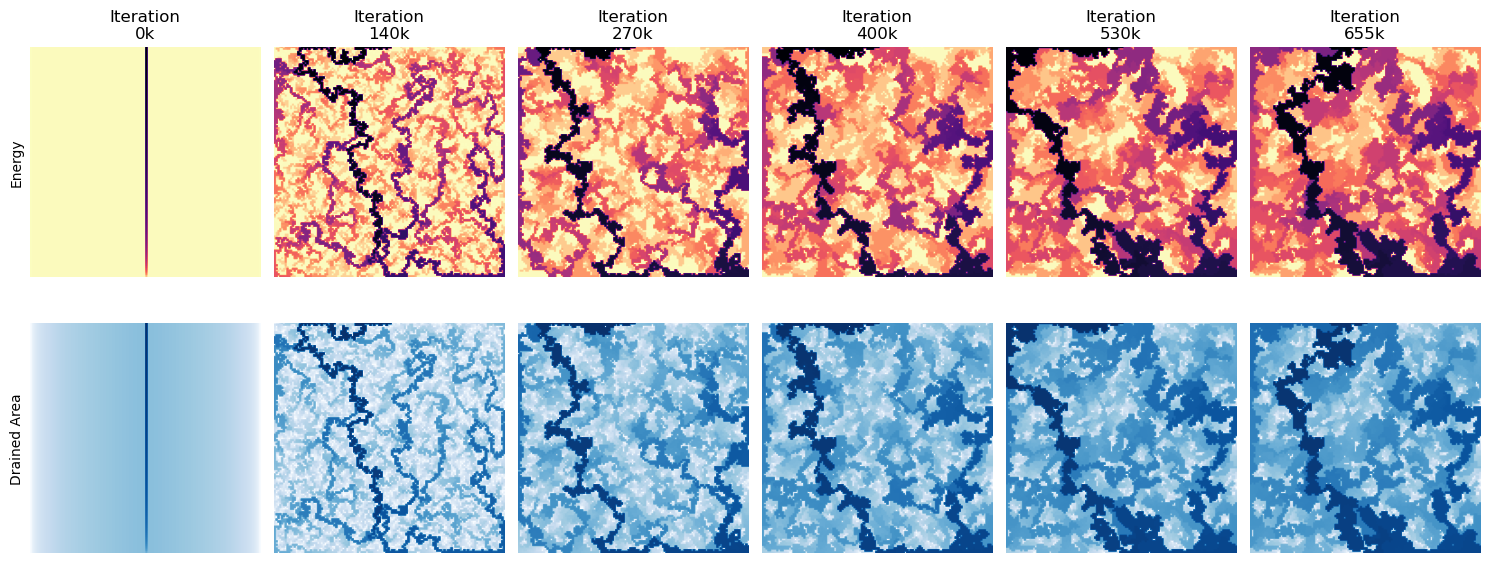

In [ ]:
fig, axs = plt.subplots(2, result.grids.shape[0], figsize=(15, 18/result.grids.shape[0]*2))
for i in range(result.grids.shape[0]):
    axs[0, i].imshow(result.grids[i,0], cmap='magma_r', norm=mpl.colors.LogNorm())
    axs[1, i].imshow(result.grids[i,1], cmap='Blues', norm=mpl.colors.LogNorm())
    axs[0, i].set_title(f"Iteration\n{result.grid_idx[i]//1000}k")
    
    axs[0, 0].set_ylabel("Energy")
    axs[1, 0].set_ylabel("Drained Area")
    
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)
    axs[1, i].spines['top'].set_visible(False)
    axs[1, i].spines['right'].set_visible(False)
    axs[0, i].spines['bottom'].set_visible(False)
    axs[0, i].spines['left'].set_visible(False)
    axs[1, i].spines['bottom'].set_visible(False)
    axs[1, i].spines['left'].set_visible(False)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
fig.tight_layout(w_pad=1, h_pad=3)

## Multi-stage optimization

In [42]:
m, n = 128, 128

# stage 1: high gamma, long
ocn = po.OCN.from_net_type("I", dims=(m,n), gamma=0.99, resolution=10.0, verbosity=2)
result_1 = ocn.fit(n_iterations=m*n*40, constant_phase=0.0, cooling_rate=1, array_reports=1)

# stage 2: low gamma, short, greedy
ocn.gamma = 0.01
result_2 = ocn.fit(n_iterations=m*n*10, constant_phase=0.0, cooling_rate=100, array_reports=1)


Converting DiGraph to FlowGrid_C...
--------------------------------------
	Graph is a directed acyclic graph.
	Graph 'pos' attributes are valid.
	Graph covers a dense 128x128 grid.
	Found 1 spanning trees.
	Edges connect only to adjacent nodes.
	Computed node attributes (drained_area, adown, edges, downstream, visited).
	Checked for crossing edges.
	Successfully created FlowGrid_C from DiGraph.
655360 655360


OCN Optimization: 100%|██████████| 655k/655k [00:07<00:00, 86.5kit/s, Energy=1.03e+8, T=5.96e-10, Relative ΔE=-3.54e-6]


163840 163840


OCN Optimization: 100%|██████████| 164k/164k [00:02<00:00, 71.8kit/s, Energy=1.73e+4, T=0, Relative ΔE=-1.2e-7]          


Text(0.5, 1.0, 'Stage 2')

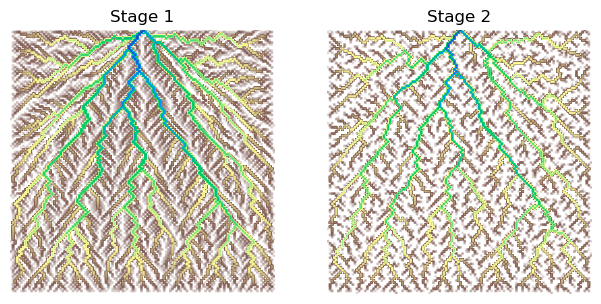

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 7.5/2))

axs[0].imshow(result_1.grids[-1, 0], cmap="terrain_r", norm=mpl.colors.LogNorm())
axs[1].imshow(result_2.grids[-1, 0], cmap="terrain_r", norm=mpl.colors.LogNorm())

for ax in axs:
    ax.set_axis_off()
axs[0].set_title("Stage 1")
axs[1].set_title("Stage 2");